In [171]:
!pip install alpha_vantage

In [0]:
MY_API_KEY = 'J4PS1W9LI8IL0E97'
ENDDATE = '2019-10-01'

from alpha_vantage.timeseries import TimeSeries
from datetime import datetime
from datetime import timedelta

TODO: add risk contribution, construction methodology, different back-testing assumption(frequency, cost, fee, etc.)

In [0]:
ONEYEARDAYS = 252
# FREQ = 90
RP_FREQ = 90
EC_FREQ = 90

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')
import os
import scipy
from scipy import optimize
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

In [0]:
ts = TimeSeries(key='MY_API_KEY', output_format='pandas')
def get_daily_close(symbol):
    full_data, meta_data = ts.get_daily(symbol = symbol, outputsize='full')
    series_index = pd.Series(full_data.index)
    full_data.index = series_index.apply(lambda t: np.datetime64(t).astype(datetime).date()).values
    assert '4. close' in full_data.columns
    close = full_data['4. close']
    close.index.name = 'Date'
    close.name = symbol
    assert close.index[0] < datetime(2006,1,3).date()
    return close[datetime(2006,1,3).date() : ]

In [0]:
SPY = get_daily_close('SPY')
TLT = get_daily_close('TLT')
GLD = get_daily_close('GLD')
assert len(SPY) == len(TLT)
assert len(TLT) == len(GLD)
m1 = pd.merge(left = SPY, left_index = True, right = TLT, right_index=True, how = 'inner')
dataall = pd.merge(left = m1, left_index = True, right = GLD, right_index=True, how = 'inner')

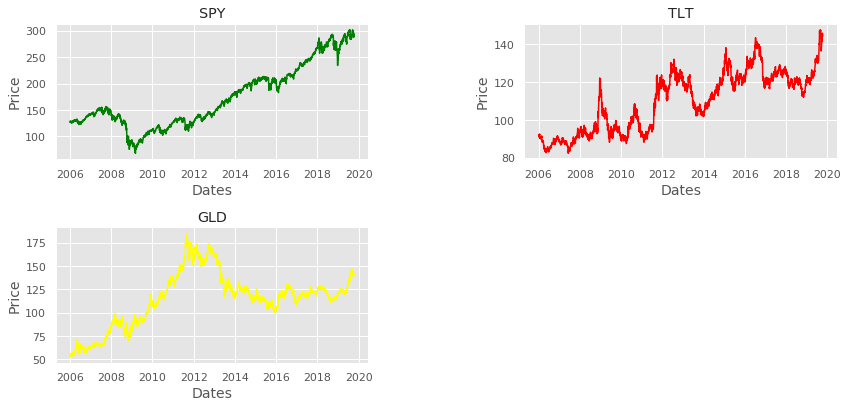

In [177]:
fig1 =plt.figure(figsize=(14,10))
plt.subplots_adjust(hspace=.5,wspace=.5) # it adds space in between plots
plt.subplot(321)
ax = plt.gca()
ax.plot(SPY, color = 'green')
ax.set_xlabel('Dates',fontsize=14)
ax.set_ylabel('Price',fontsize =14)
ax.set_title('SPY')

plt.subplot(322)
ax = plt.gca()
ax.plot(TLT, color = 'red')
ax.set_xlabel('Dates',fontsize =14)
ax.set_ylabel('Price',fontsize =14)
ax.set_title('TLT')

plt.subplot(323)
ax = plt.gca()
ax.plot(GLD, color ='yellow')
ax.set_xlabel('Dates',fontsize =14)
ax.set_ylabel('Price',fontsize =14)
ax.set_title('GLD')

plt.show();


Each assets has a different initial value which makes difficult to compare the relative performance of each asset versus the rest of them.

Let us normalize the data to compare if you would have invested one dollar at the beginning of the observation period, how much money you would have today.

$[\frac{P_{T}^{1}}{P_{0}^{1}},\frac{P_{T}^{2}}{P_{0}^{2}},\frac{P_{T}^{3}}{P_{0}^{3}}]$

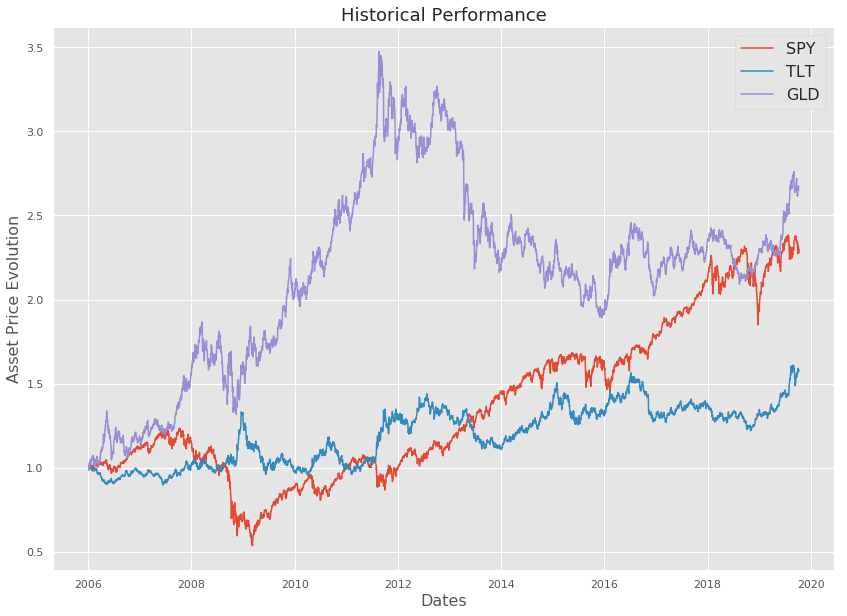

In [178]:
normalized_series = (dataall/dataall.iloc[0])
fig2 =plt.figure(figsize=(14,10))
plt.plot(normalized_series)
title_text_obj = plt.title("Historical Performance", fontsize = 18)
xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Asset Price Evolution', fontsize = 16)
plt.legend(('SPY','TLT','GLD'),fontsize = 16,loc = 'best')
plt.show()

In [0]:
## Calculating return series
returns = dataall.pct_change()
returns.dropna(inplace = True)
## Daily price changing ratio
returns_mul_factor = returns + 1
## Days and calenar
day_counts = len(spy_ret)
calendar = returns.index.values
## Calculating covariance matrix
cov_series = returns.rolling(window = RP_FREQ).cov() * ONEYEARDAYS

In [180]:
np.round(returns.corr(),2)

,SPY,TLT,GLD
SPY,1.00,-0.42,0.02
TLT,-0.42,1.00,0.13
GLD,0.02,0.13,1.00


In [0]:
# spy_ret = returns['SPY']
# tlt_ret = returns['TLT']
# gld_ret = returns['GLD']
# day_counts = len(spy_ret)
# calendar = returns.index.values

In [182]:
stats = pd.DataFrame()
stats['Annualized Returns(%)'] = returns.mean() * ONEYEARDAYS *100
stats['Annualized Volatility(%)'] = returns.std() * np.sqrt(ONEYEARDAYS)*100
stats['Sharpe Ratio'] = stats['Annualized Returns(%)'] /stats['Annualized Volatility(%)']
print(82*'-')
print('Assets Classes Annualized Statistics - full observation period')
stats.style.bar(color=['red','green'], align='zero')

----------------------------------------------------------------------------------
Assets Classes Annualized Statistics - full observation period


,Annualized Returns(%),Annualized Volatility(%),Sharpe Ratio
SPY,7.84687,18.9376,0.414354
TLT,4.25682,13.8812,0.306661
GLD,8.88876,18.6123,0.477575


  $Skewness = E\left[\left(\frac{X -\mu}{\sigma}\right)^3\right]$
  
  $Kurtosis = E\left[\left(\frac{X -\mu}{\sigma}\right)^4\right]$

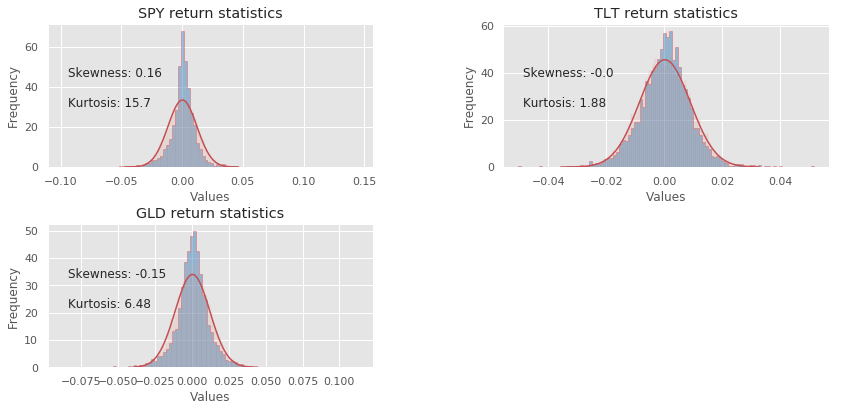

In [183]:
binsnumber = 100

fig3, ax = plt.subplots(figsize=(14,10))
plt.subplots_adjust(hspace=.4,wspace=.4) # it adds space in between plots

# asset_plot_location = {'SPY':321, 'TLT': 322 , 'GLD': 323}
# asset_list = ['SPY', 'TLT', 'GLD']

# ####
# def return_distribution_plot(name):
#     """
#     Plot function
#     """
#     fig3, ax = plt.subplots(figsize=(14,10))
#     plt.subplots_adjust(hspace=.4,wspace=.4) # it adds space in between plots
#     plt.subplot(asset_plot_location.get(name))
#     ax = plt.gca()

#     ax.hist(dataall_returns[name], bins=binsnumber, color='steelblue', density = True,
#            alpha = 0.5, histtype ='stepfilled',edgecolor ='red' )

#     sigma, mu = dataall_returns[name].std(),dataall_returns[name].mean() # mean and standard deviation
#     s = np.random.normal(mu, sigma, 1000)
#     count, bins, ignored = plt.hist(s, binsnumber, density=True, alpha = 0.1)
#     ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=1.5, color='r')

#     ax.annotate('Skewness: {}\n\nKurtosis: {}'.format(round(dataall_returns[name].skew(),2),round(dataall_returns[name].kurtosis(),2)),
#                  xy=(10,20),xycoords = 'axes points',xytext =(20,60),fontsize=12)

#     ax.set_xlabel('Values')
#     ax.set_ylabel('Frequency')
#     ax.set_title(name)
#     plt.show()
    
#####################
plt.subplot(321)
ax = plt.gca()

ax.hist(returns['SPY'], bins=binsnumber, color='steelblue', density = True,
       alpha = 0.5, histtype ='stepfilled',edgecolor ='red' )

sigma, mu = returns['SPY'].std(),returns['SPY'].mean() # mean and standard deviation
s = np.random.normal(mu, sigma, 10000)
count, bins, ignored = plt.hist(s, binsnumber, density=True, alpha = 0.1)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=1.5, color='r')

ax.annotate('Skewness: {}\n\nKurtosis: {}'.format(round(returns['SPY'].skew(),2),
                                                  round(returns['SPY'].kurtosis(),2)),
             xy=(10,20),xycoords = 'axes points',xytext =(20,60),fontsize=12)

ax.set_xlabel('Values')
ax.set_ylabel('Frequency')
ax.set_title('SPY return statistics')


#####################
plt.subplot(322)
ax = plt.gca()

ax.hist(returns['TLT'], bins=binsnumber, color='steelblue', density = True,
       alpha = 0.5, histtype ='stepfilled',edgecolor ='red' )

sigma, mu = returns['TLT'].std(),returns['TLT'].mean() # mean and standard deviation
s = np.random.normal(mu, sigma, 10000)
count, bins, ignored = plt.hist(s, binsnumber, density=True, alpha = 0.1)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=1.5, color='r')

ax.annotate('Skewness: {}\n\nKurtosis: {}'.format(round(returns['TLT'].skew(),2),
                                                  round(returns['TLT'].kurtosis(),2)),
             xy=(10,20),xycoords = 'axes points',xytext =(20,60),fontsize=12)

ax.set_xlabel('Values')
ax.set_ylabel('Frequency')
ax.set_title('TLT return statistics')


#####################
plt.subplot(323)
ax = plt.gca()

ax.hist(returns['GLD'], bins=binsnumber, color='steelblue', density = True,
       alpha = 0.5, histtype ='stepfilled',edgecolor ='red' )

sigma, mu = returns['GLD'].std(),returns['GLD'].mean() # mean and standard deviation
s = np.random.normal(mu, sigma, 10000)
count, bins, ignored = plt.hist(s, binsnumber, density=True, alpha = 0.1)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=1.5, color='r')

ax.annotate('Skewness: {}\n\nKurtosis: {}'.format(round(returns['GLD'].skew(),2),
                                                  round(returns['GLD'].kurtosis(),2)),
             xy=(10,20),xycoords = 'axes points',xytext =(20,60),fontsize=12)

ax.set_xlabel('Values')
ax.set_ylabel('Frequency')
ax.set_title('GLD return statistics')

plt.show();
# fig3.savefig('histos.png',dpi=fig3.dpi)

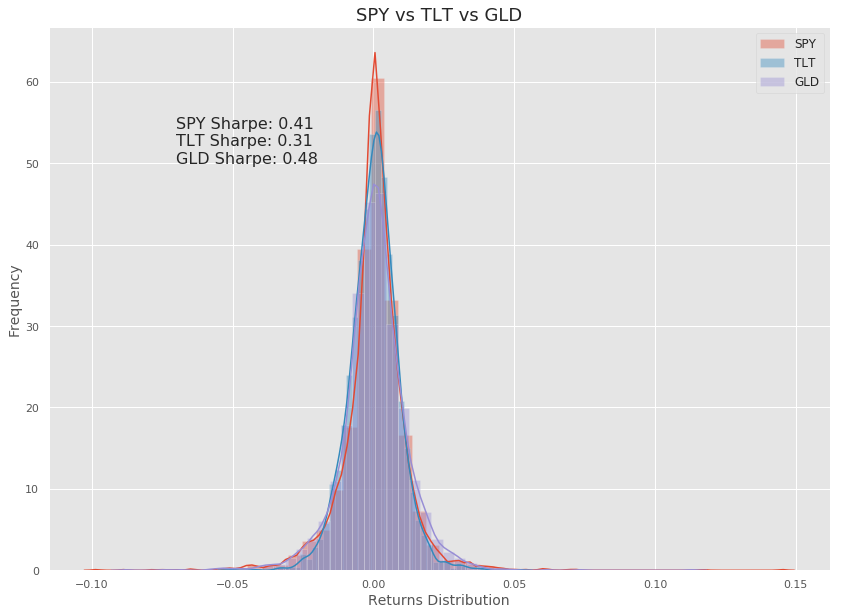

In [184]:
fig4 = plt.figure(figsize=(14,10))
sns.distplot(returns['SPY'])
sns.distplot(returns['TLT'])
sns.distplot(returns['GLD'])
plt.legend(('SPY','TLT','GLD'),fontsize = 12)

# anotate an important value
plt.annotate(' \nSPY Sharpe: {}\nTLT Sharpe: {} \nGLD Sharpe: {}'.format(round(stats.loc['SPY','Sharpe Ratio'],2),round(stats.loc['TLT','Sharpe Ratio'],2), round(stats.loc['GLD','Sharpe Ratio'],2)),
             xy=(-.01,40),xycoords = 'data',xytext =(-.07, 50),fontsize=16)
plt.title('SPY vs TLT vs GLD',fontsize=18)
plt.xlabel('Returns Distribution', fontsize= 14)
plt.ylabel('Frequency',fontsize=14)
plt.show();

## Risk Parity:
$$ r_p = \sum_{i}^{N}x_{i}r_{i}, \sigma_{p} = \sqrt{\sum_{i}^{N}\sum_{j}^{N}x_{i}x_{j}\sigma_{ij}}$$

Marginal Risk Contribution (MRC):
$$MRC_{i} = \frac{\partial{\sigma_p}}{\partial{x_i}} = \sum_{i}^{N} \frac{x_i\sigma_{ij}}{\sigma_p} = cov(r_i, r_p)/\sigma_p$$

Marginal Risk Contribution shows the increase of portfolio risk when we increase a unit of the asset $x_i$, so we can get the Total Risk Contribution (TRC)

$$TRC_i = x_i \frac{\partial{\sigma_p}}{\partial{x_i}} = \sum_{i}^{N} x_i x_j \sigma_{ij}/ \sigma_p  = x_i cov(r_i, r_p)/ \sigma_p$$

If we sum up all the Total Risk Contribution of asset $x_i$ we got :
$$ \sum_{i}^{N} TRC_i = \sum_{i}^{N} x_i cov(r_i, r_p) = \sigma_p$$

If we need to allocate risk equally, we need to make sure 
$$ x_i \frac{\sigma_p}{\sigma_i} = x_j \frac{\sigma_p}{\sigma_j} = \lambda, \forall i,j$$

In realistic numerical optimization, we can solve like this:
$$ min \sum_{i}^{N}\sum_{j}^{N}(TRC_i - TRC_j)^2$$
$$ s.t. \sum_{i}^{N} x_i = 1$$

In [0]:
def equal_risk(weight, cov):
    TRC1 = weight[0]**2 * cov.iloc[0, 0] + \
        weight[0]*weight[1] * cov.iloc[1,0] + \
        weight[0]*(1 - weight[0] - weight[1]) * cov.iloc[2,0]
        
    TRC2 = weight[0]*weight[1] * cov.iloc[0,1] + \
        weight[1]**2 * cov.iloc[1,1] + \
        weight[1]*(1 - weight[0] - weight[1]) * cov.iloc[2,1]
        
    TRC3 = weight[0]*(1 - weight[0] - weight[1]) * cov.iloc[0,2] + \
        weight[1]*(1 - weight[0] - weight[1]) * cov.iloc[1,2] + \
        (1 - weight[0] - weight[1])**2 * cov.iloc[2,2]
        
    return np.square(TRC1 - TRC2)+ np.square(TRC2 - TRC3) + np.square(TRC1 - TRC3)

def TRC(weight,cov):
    TRC1 = weight[0]**2 * cov.iloc[0, 0] + \
        weight[0]*weight[1] * cov.iloc[1,0] + \
        weight[0]*(1 - weight[0] - weight[1]) * cov.iloc[2,0]
        
    TRC2 = weight[0]*weight[1] * cov.iloc[0,1] + \
        weight[1]**2 * cov.iloc[1,1] + \
        weight[1]*(1 - weight[0] - weight[1]) * cov.iloc[2,1]
        
    TRC3 = weight[0]*(1 - weight[0] - weight[1]) * cov.iloc[0,2] + \
        weight[1]*(1 - weight[0] - weight[1]) * cov.iloc[1,2] + \
        (1 - weight[0] - weight[1])**2 * cov.iloc[2,2]
    
    return np.array([TRC1, TRC2, TRC3])
    
def weight_calculation(cov_df):
    ans = minimize(equal_risk, [0.0, 0.0], (cov_df), method='L-BFGS-B',  bounds=((0,1), (0,1)))
    result = []
    result.extend(list(ans.x))
    result.append(1- ans.x.sum())
    return np.array(result)

In [0]:
def Backtest(frequency,method, get_partial_riskcontribution = False):
    if method == "Equal Risk":
        ## Get Covariance matrix based on frequency and rebalancing dates
        all_cov = []
        for i in range(1,day_counts//frequency + 1):
            ## Indexing the covariance matrix, in pair of (date, covariance matrix)
            all_cov.append( (cov_series.index[(i*frequency-1)*3][0] ,cov_series.iloc[(i*frequency-1)*3 : i*frequency*3]))
        ## Get rebalancing date and weight
        rebalance_pair = {}
        equal_risk_result = {}
        equal_risk_contribution = {}
        cov_date_pair = {}
        for i in range(len(all_cov)):
            res = weight_calculation(all_cov[i][1])
            rebalance_pair.update({all_cov[i][0] : res})
            cov_date_pair.update({all_cov[i][0] : all_cov[i][1]})
            
        rebalance_pair = pd.Series(rebalance_pair)
        rebalance_date = rebalance_pair.index.values
        rebalance_weight = rebalance_pair.values

        new_calendar = calendar[calendar > rebalance_date[0]]
#         pre_calendar = calendar[calendar <= rebalance_date[0]]
        
#         for date in pre_calendar:
#             equal_risk_result.update({date : 1000})
        
        ## backtest equal risk result
        current_asset = rebalance_weight[0] * 1000
        current_weight = rebalance_weight[0]
        current_cov = cov_date_pair.get(rebalance_date[0])
        equal_risk_result.update({rebalance_date[0] : 1000})
        
        
            
        for date in new_calendar:

            if date not in rebalance_date:
                current_asset = current_asset * (returns_mul_factor.loc[date].values)
                current_level = current_asset.sum()
                equal_risk_result.update({date: current_level})
                equal_risk_contribution.update({date: TRC(current_weight, current_cov)})
                
            elif date in rebalance_date:
                current_asset = current_asset * (returns_mul_factor.loc[date].values)
                current_level = current_asset.sum()
                current_asset = rebalance_pair[date] * current_level
                current_weight = rebalance_pair.get(date)
                
                current_cov = cov_date_pair.get(date)
                equal_risk_result.update({date: current_level})
                equal_risk_contribution.update({date: TRC(current_weight, current_cov)})
                
        equal_risk_result = pd.Series(equal_risk_result)
        equal_risk_contribution = pd.Series(equal_risk_contribution)
        
        if get_partial_riskcontribution == True:
            return equal_risk_result, equal_risk_contribution
        else:
            return equal_risk_result
        
    elif method == "Equal Capital":
        ## Get rebalancing date and weight
        rebalance_date = []
        equal_capital_result = {}
        for i in range(1,day_counts//frequency + 1):        
            rebalance_date.append(cov_series.index[(i*frequency-1)*3][0])
        new_calendar = calendar[calendar > rebalance_date[0]]
#         pre_calendar = calendar[calendar <= rebalance_date[0]]
        
#         for date in pre_calendar:
#             equal_capital_result.update({date : 1000})
            
        ## backtest equal capital result
        equal_capital_weight = np.array([1,1,1])/3
        current_asset = equal_capital_weight * 1000
        equal_capital_result.update({rebalance_date[0] : 1000})

        for date in new_calendar:

            if date not in rebalance_date:
                current_asset = current_asset * (returns_mul_factor.loc[date].values)
                current_level = current_asset.sum()
                equal_capital_result.update({date: current_level})
            elif date in rebalance_date:
                current_asset = current_asset * (returns_mul_factor.loc[date].values)
                current_level = current_asset.sum()
                current_asset = equal_capital_weight * current_level
                equal_capital_result.update({date: current_level})

        equal_capital_result = pd.Series(equal_capital_result)
        return equal_capital_result
        

In [0]:
backtest_result = pd.DataFrame()
backtest_result['Equal Capital'] = Backtest(frequency=60, method = "Equal Capital")
backtest_result['Equal Risk'] = Backtest(frequency=60, method = "Equal Risk")
strategy_return = backtest_result.pct_change().dropna()
strategy_return;

In [0]:
def performance_analysis(strategy_return):
    strategy_stats = pd.DataFrame()
    strategy_stats['Annualized Returns(%)'] = strategy_return.mean() * ONEYEARDAYS *100
    strategy_stats['Annualized Volatility(%)'] = strategy_return.std() * np.sqrt(ONEYEARDAYS)*100
    strategy_stats['Sharpe Ratio'] = strategy_stats['Annualized Returns(%)'] /strategy_stats['Annualized Volatility(%)']
    
    return strategy_stats

In [189]:
strategy_stats = performance_analysis(strategy_return=strategy_return)
print('Strategy Performance Annualized Statistics - full observation period')
strategy_stats.style.bar(color=['red','green'], align='zero')

Strategy Performance Annualized Statistics - full observation period


,Annualized Returns(%),Annualized Volatility(%),Sharpe Ratio
Equal Capital,6.51402,9.06412,0.71866
Equal Risk,6.81089,9.08222,0.749914


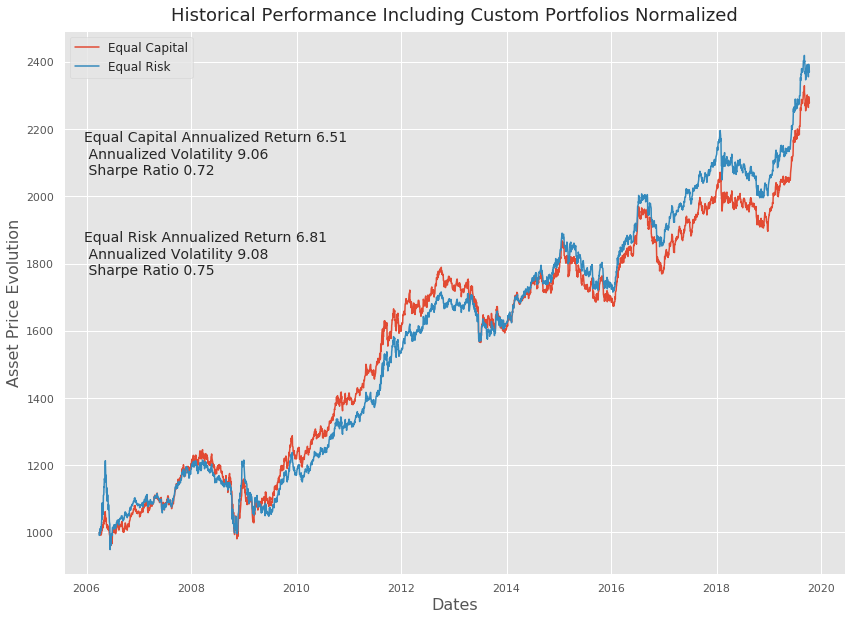

In [190]:
fig6 =plt.figure(figsize=(14,10))
ax = plt.gca()
ax.plot(backtest_result[['Equal Capital', 'Equal Risk']])

title_text_obj = plt.title("Historical Performance Including Custom Portfolios Normalized", fontsize = 18,
                          verticalalignment = 'bottom')
xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Asset Price Evolution', fontsize = 16)
ax.legend(('Equal Capital', 'Equal Risk'),fontsize = 12)
ax.annotate('Equal Capital Annualized Return {}\n Annualized Volatility {}\n Sharpe Ratio {}'.format(
            np.round(strategy_stats['Annualized Returns(%)']['Equal Capital'],2),
            np.round(strategy_stats['Annualized Volatility(%)']['Equal Capital'],2),
            np.round(strategy_stats['Sharpe Ratio']['Equal Capital'],2)),
            xy=(20,400),xycoords = 'axes points',fontsize=14)

ax.annotate('Equal Risk Annualized Return {}\n Annualized Volatility {}\n Sharpe Ratio {}'.format(
            np.round(strategy_stats['Annualized Returns(%)']['Equal Risk'],2),
            np.round(strategy_stats['Annualized Volatility(%)']['Equal Risk'],2),
            np.round(strategy_stats['Sharpe Ratio']['Equal Risk'],2)),
            xy=(20,300),xycoords = 'axes points',fontsize=14)
plt.show()
# fig6.savefig('portfolioscomp.png',dpi=fig6.dpi)

In [0]:
backtest_result2 = pd.DataFrame()
backtest_result2['Equal Risk 60 day rebalance'] = Backtest(frequency = 60, method = "Equal Risk")
backtest_result2['Equal Risk 90 day rebalance'] = Backtest(frequency= 90, method = "Equal Risk")
backtest_result2_nafilled = backtest_result2.fillna(1000)

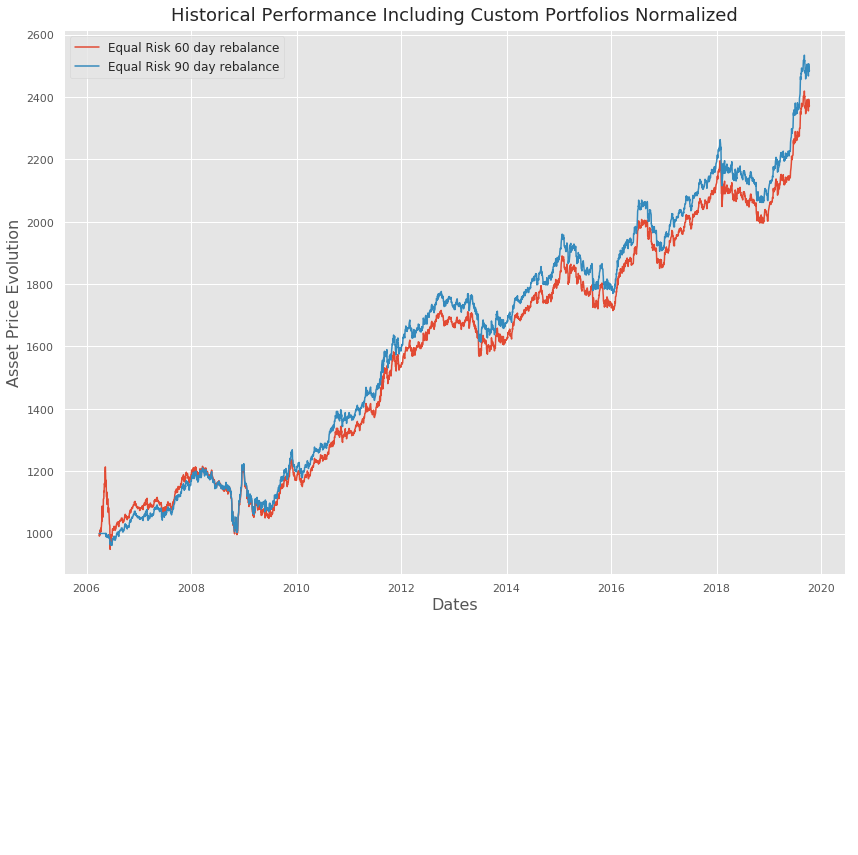

In [192]:
fig6 =plt.figure(figsize=(14,10))
ax = plt.gca()
ax.plot(backtest_result2_nafilled[['Equal Risk 60 day rebalance', 'Equal Risk 90 day rebalance']])

title_text_obj = plt.title("Historical Performance Including Custom Portfolios Normalized", fontsize = 18,
                          verticalalignment = 'bottom')

xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Asset Price Evolution', fontsize = 16)
ax.legend(('Equal Risk 60 day rebalance', 'Equal Risk 90 day rebalance'),fontsize = 12)
ax.annotate('EM Portfolio provides \nhigher risk adjusted return',('2018-04-30',1.4),xycoords = 'data',xytext =('2013-08-30',1.4),arrowprops =dict(arrowstyle ='->'),fontsize=14)
plt.show()
# fig6.savefig('portfolioscomp.png',dpi=fig6.dpi)